# Extraction Demo 

With this notebook, light-field decomposition to Sub-Aperture Images (SAIs) and refocused image slices is presented. Thispart is based on an aligned light-field in form of a pickle file rendered using **[PlenoptiCam](https://github.com/hahnec/plenopticam)** as shown in [02_align_demo.ipynb](./02_align_demo.ipynb).

## Package and import prerequisites

In [1]:
import sys, os
print('Python v'+sys.version+'\n')

try:
    import plenopticam as pcam
except ImportError:
    !pip install plenopticam>=0.7.0
    import plenopticam as pcam
print('PlenoptiCam v'+pcam.__version__+'\n')

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib --upgrade
    import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML

%matplotlib inline

Python v3.7.7 (v3.7.7:d7c567b08f, Mar 10 2020, 02:56:16) 
[Clang 6.0 (clang-600.0.57)]

PlenoptiCam v0.7.0



## Image data acquisition
Available plenoptic photographs can be downloaded to the current folder ('./data') using the featured `DataDownloader` class, which is also used for extracting archived files.

In [2]:
loader = pcam.misc.DataDownloader()
loader.download_data(loader.opex_prep_url, fp='./data')
loader.extract_archive(archive_fn='./data/OpEx_data_prepared.zip')

Download skipped as OpEx_data_prepared.zip already exists
Extracted file f197with4m11pxFinal/lfp_img_align.pkl


## Configuration of *PlenoptiCam*

Before running the process, configurations such as file paths need to be set, using the `PlenopticamConfig` class as follows

In [3]:
# instantiate config object and set image file paths and options
cfg = pcam.cfg.PlenopticamConfig()
cfg.default_values()
cfg.params[cfg.lfp_path] = './data/f197with4m11pxFinal.bmp'
cfg.params[cfg.cal_meta] = './data/f197with4m11pxf16Final.json'
cfg.params[cfg.ptc_leng] = 9
cfg.params[cfg.opt_dpth] = True
print(cfg.params[cfg.opt_vign])

# load calibration data
cfg.load_cal_data()

# instantiate status object to display processing progress
sta = pcam.misc.PlenopticamStatus()

False


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/plenopticam-0.7.0-py3.7.egg/plenopticam/cfg/cfg.py:107: UserWarning: 

Grant permission to write to the config file /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/plenopticam-0.7.0-py3.7.egg/plenopticam/cfg/cfg.json
  warnings.warn('\n\nGrant permission to write to the config file '+fp, UserWarning)


## Load aligned light-field

In [4]:
try:
    import pickle
    # load previously computed light field alignment
    fp = os.path.join(cfg.exp_path, 'lfp_img_align.pkl')
    lfp_img_align = pickle.load(open(fp, 'rb'))
except EOFError:
    os.remove(fp)

## Sub-Aperture Image (SAI) extraction

Rendering perspective views, known as SAIs, from an aligned light-field image `lfp_img_align` is accomplished by a series of classes in the `lfp_extractor` module. The resulting `vp_img_arr` is displayed in various ways further below.

In [5]:
# micro image crop
lfp_obj = pcam.lfp_extractor.LfpCropper(lfp_img_align=lfp_img_align, cfg=cfg, sta=sta)
lfp_obj.main()
lfp_img_align = lfp_obj.lfp_img_align

# rearrange light-field to sub-aperture images
if cfg.params[cfg.opt_view]:
    obj = pcam.lfp_extractor.LfpRearranger(lfp_img_align, cfg=cfg, sta=sta)
    obj.main()
    vp_img_linear = obj.vp_img_arr
    del obj

# remove outliers if option is set
if cfg.params[cfg.opt_lier]:
    obj = pcam.lfp_extractor.LfpOutliers(vp_img_arr=vp_img_linear, cfg=cfg, sta=sta)
    obj.main()
    vp_img_linear = obj.vp_img_arr
    del obj

# color equalization
if cfg.params[cfg.opt_colo]:
    obj = pcam.lfp_extractor.LfpColorEqualizer(vp_img_arr=vp_img_linear, cfg=cfg, sta=sta)
    obj.main()
    vp_img_linear = obj.vp_img_arr
    del obj

# copy light-field before gamma encoding for refocusing process (prior to contrast and export)
vp_img_arr = vp_img_linear.copy() if vp_img_linear is not None else None

# color management automation
obj = pcam.lfp_extractor.LfpContrast(vp_img_arr=vp_img_arr, cfg=cfg, sta=sta)
obj.main()
vp_img_arr = obj.vp_img_arr
del obj

# reduction of hexagonal sampling artifacts
if cfg.params[cfg.opt_arti]:
    obj = pcam.lfp_extractor.HexCorrector(vp_img_arr=vp_img_arr, cfg=cfg, sta=sta)
    obj.main()
    vp_img_arr = obj.vp_img_arr
    del obj

# write viewpoint data to hard drive
if cfg.params[cfg.opt_view]:
    obj = pcam.lfp_extractor.LfpExporter(vp_img_arr=vp_img_arr, cfg=cfg, sta=sta)
    obj.write_viewpoint_data()


 Viewpoint composition
 Progress: Finished 


 Color equalization
 Progress: Finished 


 Write viewpoint images
 Progress: Finished 



In [6]:
view_obj = pcam.lfp_extractor.LfpViewpoints(vp_img_arr=vp_img_arr)

vp_img_arr.shape
vp_arr = view_obj.reorder_vp_arr(pattern='circle', lf_radius=3)

fig, ax = plt.subplots()
ax.set_title('View animation')
l = ax.imshow(vp_arr[0])
animate = lambda i: l.set_data(vp_arr[i])
anim = animation.FuncAnimation(fig, animate, frames=len(vp_arr), interval=50)
plt.close() # get rid of initial figure

HTML(anim.to_jshtml())

## Computational change of focus

The light-field's well known synthetic focus capability is managed by the `LfpRefocuser` class with exemplary parameter setting $a=[0,2]$ in the `cfg.params` dictionary and key `cfg.ran_refo` controling the refocused range.

In [7]:
# set refocus range $a$
cfg.params[cfg.ran_refo] = [0, 2]
# skip status messages
cfg.params[cfg.opt_prnt] = False

refocuser = pcam.lfp_refocuser.LfpRefocuser(vp_img_arr=vp_img_linear, cfg=cfg)
refocuser.main()
refo_stack = refocuser.refo_stack

fig, ax = plt.subplots()
ax.set_title('Refocusing animation')
l = ax.imshow(refo_stack[0])
animate = lambda i: l.set_data(refo_stack[i])
anim = animation.FuncAnimation(fig, animate, frames=len(refo_stack), interval=1000)
plt.close() # get rid of initial figure

HTML(anim.to_jshtml())

## Depth extraction

Depth inference from light-fields is a capability *PlenoptiCam* offers by means of the `LfpDepth` class using the parameter key `cfg.opt_dpth` in the `cfg.params` dictionary.

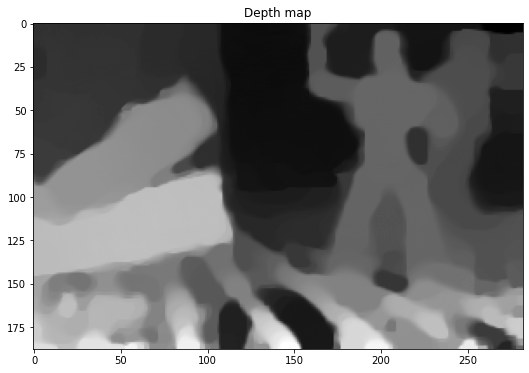

In [8]:
# compute and write depth data from epipolar analysis
if cfg.params[cfg.opt_dpth]:
    obj = pcam.lfp_extractor.LfpDepth(vp_img_arr=vp_img_arr, cfg=cfg, sta=sta)
    obj.main()
    depth_map = obj.depth_map

# plot depth map in 2-D
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Depth map')
ax.imshow(depth_map, cmap='gray')
plt.show()

In [9]:
# plot depth map in 3-D
fig, ax = plt.figure(figsize=(5, 5)), plt.axes(projection='3d')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
obj.plot_point_cloud(rgb_img=obj.central_view, down_scale=1, ax=ax, s=2)
plt.close() # get rid of initial figure
animate = lambda i: ax.view_init(60, 60+i*10)
anim = animation.FuncAnimation(fig, animate, frames=18*2, interval=100, repeat=True)
HTML(anim.to_jshtml())